# CS 6330
## Final Project
## Distinguish Between Sitting, Walking, and Stair Climbing
### Robert Burkhardt
### Dan Olson
### Rich Lukas
### 2/14/23

### Load Libraries

In [1]:
from collections import defaultdict as dd
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from ModelAuto.Multicollinearity import handel_Multico_VIF
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from numpy import *
from numpy import linalg as LA
from patsy import dmatrices
from pylab import *
from scipy import signal
from scipy.sparse import csr_matrix, find
from scipy.stats import chisquare
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import rand_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import scipy as sci
import scipy.stats as stats
import seaborn as sns
import sklearn
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import statistics 
import statsmodels.api as sm
import tensorflow as tf
import time
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
print("Libraries Loaded")

Libraries Loaded


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



## Helper functions

In [3]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError( "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y


def smooth_demo():

    t=linspace(-4,4,100)
    x=sin(t)
    xn=x+randn(len(t))*0.1
    y=smooth(x)

    ws=31

    subplot(211)
    plot(ones(ws))

    windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

    hold(True)
    for w in windows[1:]:
        eval('plot('+w+'(ws) )')

    axis([0,30,0,1.1])

    legend(windows)
    title("The smoothing windows")
    subplot(212)
    plot(x)
    plot(xn)
    for w in windows:
        plot(smooth(xn,10,w))
    l=['original signal', 'signal with noise']
    l.extend(windows)

    legend(l)
    title("Smoothing a noisy signal")
    show()

def gauss_kern(size, sizey=None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = mgrid[-size:size+1, -sizey:sizey+1]
    g = exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

def blur_image(im, n, ny=None) :
    """ blurs the image by convolving with a gaussian kernel of typical
        size n. The optional keyword argument ny allows for a different
        size in the y direction.
    """
    g = gauss_kern(n, sizey=ny)
    improc = signal.convolve(im,g, mode='valid')
    return(improc)

#!python
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError( msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

import os
 
# Function to Get the current
# working directory
def current_path():
    print("Current working directory before")
    print(os.getcwd())
    print()

##  Read in Data files into a combined dataframe

In [12]:
#display(HTML("<script>$('div.cell.selected').children('div.output_wrapper').height(800);</script>"))
df_stairs = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed','type'])
df_walking = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])
df_sitting = pd.DataFrame(columns=['time','gFx','gFy','gFz','wx','wy','wz','Unnamed: 7','time_elapsed'])

os.chdir('C:/msoe/CC6330/Projects/VIrtual/env/Final/cs6330-final-project/data/richard-raw/Logs_climbing_stairs')
#os.chdir('./Stairs')
# Get the list of all files and directories
for x in os.listdir():
    if x.endswith(".csv"):
        df = pd.read_csv(x)
        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'S'
        df_stairs = df_stairs.append(df, ignore_index=True) 
df_stairs = df_stairs.drop('Unnamed: 7', axis=1) 
df_stairs.reset_index(inplace = True,drop=True)
df_stairs = df_stairs.dropna(axis = 0, how ='any')

os.chdir('C:/msoe/CC6330/Projects/VIrtual/env/Final/cs6330-final-project/data/richard-raw/Logs_walking_straight')
#os.chdir('./Walking')
# Get the list of all files and directories
for x in os.listdir():
    if x.endswith(".csv"):
        df = pd.read_csv(x)
        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'W'
        df_walking = df_walking.append(df, ignore_index=True) 
df_walking = df_walking.drop('Unnamed: 7', axis=1) 
df_walking = df_walking.dropna(axis = 0, how ='any')
df_walking.reset_index(inplace = True,drop=True)

os.chdir('C:/msoe/CC6330/Projects/VIrtual/env/Final/cs6330-final-project/data/richard-raw/Sitting')
#os.chdir('./Sitting')
# Get the list of all files and directories
for x in os.listdir():
    if x.endswith(".csv"):
        df = pd.read_csv(x)
        df['time_elapsed'] = round(df['time']*1e6)
        df['type'] = 'C' #sitting
        df_sitting = df_sitting.append(df, ignore_index=True) 
df_sitting = df_sitting.drop('Unnamed: 7', axis=1) 
df_sitting = df_sitting.dropna(axis = 0, how ='any')
df_sitting.reset_index(inplace = True,drop=True)

df_combined = df_walking.append(df_stairs, ignore_index=True) 
df_combined.reset_index(inplace = True,drop=True)
df_combined = df_combined.append(df_sitting, ignore_index=True) 
df_combined.reset_index(inplace = True,drop=True)

df_combined.tail()

,time,gFx,gFy,gFz,wx,wy,wz,time_elapsed,type
143865,30.155494,-0.0561,-0.0650,-0.9945,0.0011,-0.0009,-0.0041,30155494.0,C
143866,30.156669,-0.0561,-0.0650,-0.9945,0.0011,-0.0009,-0.0041,30156669.0,C
143867,30.157532,-0.0552,-0.0660,-0.9940,0.0011,-0.0009,-0.0041,30157532.0,C
143868,30.158200,-0.0539,-0.0674,-0.9943,0.0011,-0.0009,-0.0041,30158200.0,C
143869,30.158822,-0.0540,-0.0653,-0.9938,0.0011,-0.0009,-0.0041,30158822.0,C


### Perform Truncated SVD

Select n = 3 components

The size of the X_svd is 143870 by 4

The explained_variance is  [3.12108901 1.5274322  0.48413468 0.477351  ]

The explained_variance_ratio is  [0.51233058 0.25072986 0.0794713  0.07835775]

The explained_variance_ratio_.sum() is  0.9208894952171834

The trun_svd.singular_values  [671.00409725 478.23277639 420.40670952 262.95280136]

The n_features_in_ is  6


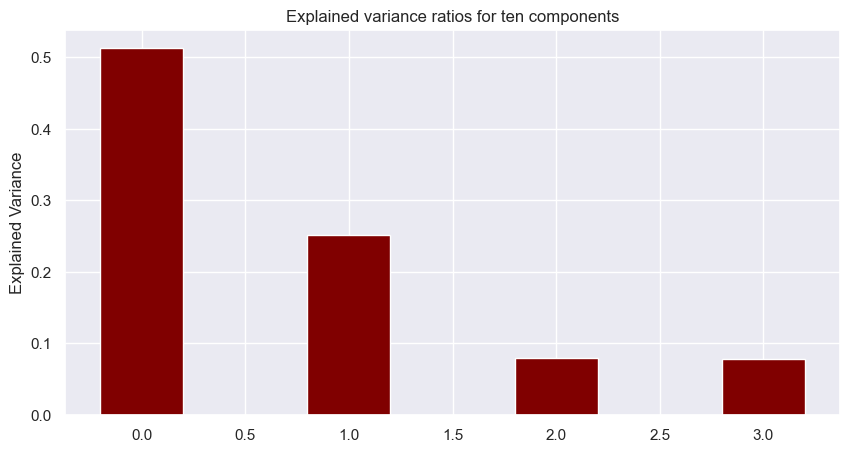

In [13]:
X_matrix = df_combined[['gFx','gFy','gFz','wx','wy','wz']]
y = df_combined.type

trun_svd =  TruncatedSVD(n_components = 4)
print("Select n = 3 components")
X_svd = trun_svd.fit_transform(X_matrix)
print('\nThe size of the X_svd is ' + str(X_svd.shape[0]) + ' by ' + str(X_svd.shape[1]) )
print("\nThe explained_variance is ",trun_svd.explained_variance_)
print("\nThe explained_variance_ratio is ",trun_svd.explained_variance_ratio_)
x = trun_svd.explained_variance_ratio_
print("\nThe explained_variance_ratio_.sum() is ",trun_svd.explained_variance_ratio_.sum())
print("\nThe trun_svd.singular_values ", trun_svd.singular_values_) #n_features_in_
print("\nThe n_features_in_ is ", trun_svd.n_features_in_) #n_features_in_
#print("feature_names_in_ ", trun_svd.feature_names_in_) #n_features_in_

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(range(0,len(trun_svd.explained_variance_ratio_)), trun_svd.explained_variance_ratio_, color ='maroon', width = 0.4)
plt.ylabel("Components")
plt.ylabel("Explained Variance")
plt.title("Explained variance ratios for ten components")
plt.show()

### Plot 2D Clusters

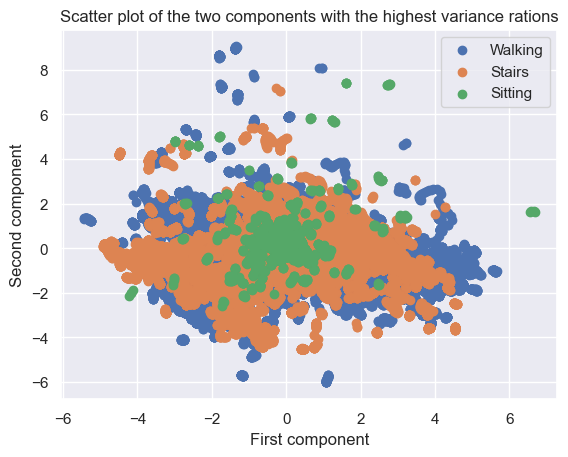

In [14]:
#X_proj = trun_svd.transform(X_matrix)
#print(X_proj.shape[0])
I= df_combined[df_combined['type']=='W'].index
J= df_combined[df_combined['type']=='S'].index
K= df_combined[df_combined['type']=='C'].index
#print(max(I))
plt.scatter(X_svd[I, 0], X_svd[I, 1])
plt.scatter(X_svd[J, 0], X_svd[J, 1])
plt.scatter(X_svd[K, 0], X_svd[K, 1])
plt.title('Scatter plot of the two components with the highest variance rations')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.legend(["Walking","Stairs","Sitting"])

plt.show()
#X_svd

### Test Train Stratified split with Scaling

In [15]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X = df_combined.copy()
X.pop('time')
X.pop('time_elapsed')
y = X.pop('type')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
print('\nThe size of the X_train is ' + str(X_train.shape[0]) + ' by ' + str(X_train.shape[1]) )
print('\nThe size of the X_test is ' + str(X_test.shape[0]) + ' by ' + str(X_test.shape[1]) )
scaler = preprocessing.StandardScaler().fit(X_train)
#min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


The size of the X_train is 107902 by 6

The size of the X_test is 35968 by 6


### Perform Logistic Classification

#### This model performs poorly

Score:  1.0
Accuracy:  0.5750667259786477
      W     S      C
W  2038     4   1023
S   270   671  12238
C   709  1040  17975


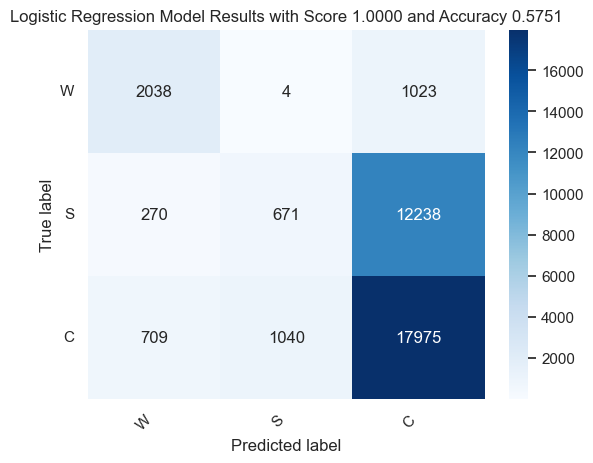

"\nfpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)\nsns.set()\nplt.plot(fpr, tpr)\nplt.plot(fpr, fpr, linestyle = '--', color = 'k')\nplt.xlabel('False positive rate')\nplt.ylabel('True positive rate')\nAUROC = np.round(roc_auc_score(y_test, y_pred_proba), 3)\nplt.title(f'Logistic Regression Model ROC curve; AUROC: {AUROC}');\nplt.show()\n\n\n\nfrom sklearn.metrics import precision_recall_curve\nfrom sklearn.metrics import average_precision_score\naverage_precision = average_precision_score(y_test1, y_pred_proba)\nprecision, recall, thresholds = precision_recall_curve(y_test1, y_pred_proba)\nplt.plot(recall, precision, marker='.', label='Logistic')\nplt.xlabel('Recall')\nplt.ylabel('Precision')\nplt.legend()\naverage_precision = np.round(average_precision, 3)\nplt.title(f'Precision Recall Curve. AUPRC: {average_precision}')\nplt.show()\n"

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto').fit(X_train, y_train)
yhat = LR.predict(X_test )

Score_model = round(LR.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
print("Score: ", round(LR.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))

conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(LR.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('Logistic Regression Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
plt.show() 

y_pred_proba = LR.predict_proba(np.array(X_test))[:,1]
y_test1 = y_test.replace('W',  1)
y_test1 = y_test1.replace('S',  0)
y_test1 = y_test1.replace('C',  2)

'''
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)
sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
AUROC = np.round(roc_auc_score(y_test, y_pred_proba), 3)
plt.title(f'Logistic Regression Model ROC curve; AUROC: {AUROC}');
plt.show()



from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test1, y_pred_proba)
precision, recall, thresholds = precision_recall_curve(y_test1, y_pred_proba)
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
average_precision = np.round(average_precision, 3)
plt.title(f'Precision Recall Curve. AUPRC: {average_precision}')
plt.show()
'''

### Perform SVM Classification

#### This works poorly

c:\python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Score:  1.0
Accuracy:  0.5489551808617956
     C    W      S
C  183   18   1592
W   81  621  12476
S  506  976  18242


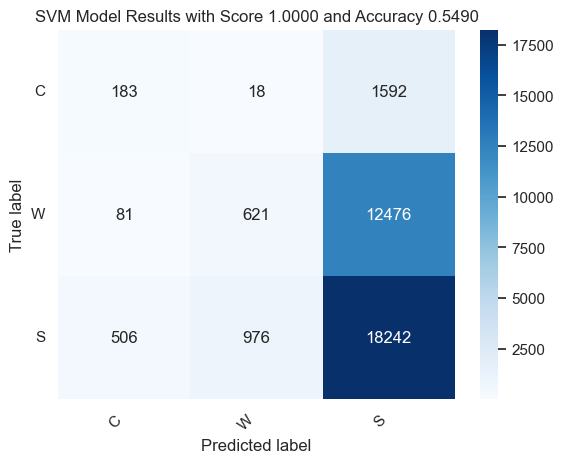

"\n\n\nfpr, tpr, thresholds = roc_curve(y_test1, res)  #fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)\nsns.set()\nplt.plot(fpr, tpr)\nplt.plot(fpr, fpr, linestyle = '--', color = 'k')\nplt.xlabel('False positive rate')\nplt.ylabel('True positive rate')\nAUROC = np.round(roc_auc_score(y_test, res), 3)\nplt.title(f'SVM Model ROC curve; AUROC: {AUROC}');\nplt.show()\n\nfrom sklearn.metrics import precision_recall_curve\nfrom sklearn.metrics import average_precision_score\naverage_precision = average_precision_score(y_test1, res)\nprecision, recall, thresholds = precision_recall_curve(y_test1, res)\nplt.plot(recall, precision, marker='.', label='SVM')\nplt.xlabel('Recall')\nplt.ylabel('Precision')\nplt.legend()\naverage_precision = np.round(average_precision, 3)\nplt.title(f'Precision Recall Curve. AUPRC: {average_precision}')\nplt.show()\n"

In [162]:
from sklearn import svm

SVM = svm.LinearSVC()
SVM.fit(X_train, y_train)
yhat = SVM.predict(X_test )
print("Score: ", round(SVM.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(SVM.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('SVM Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
#plt.title('SVM Model Results')
plt.show() 


#y_pred_proba = SVM.predict_proba(np.array(X_test))[:,1]
res= SVM._predict_proba_lr(X_test)[:,1]
y_test1 = y_test.replace('W',  1)
y_test1 = y_test1.replace('S',  0)
y_test1 = y_test1.replace('C',  2)

'''
fpr, tpr, thresholds = roc_curve(y_test1, res)  #fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)
sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
AUROC = np.round(roc_auc_score(y_test, res), 3)
plt.title(f'SVM Model ROC curve; AUROC: {AUROC}');
plt.show()

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test1, res)
precision, recall, thresholds = precision_recall_curve(y_test1, res)
plt.plot(recall, precision, marker='.', label='SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
average_precision = np.round(average_precision, 3)
plt.title(f'Precision Recall Curve. AUPRC: {average_precision}')
plt.show()
'''

### Perform Random Forest Classification

#### This works slightly better

Score:  1.0
Accuracy:  0.6119325551232166
      C  W      S
C  1518  0    275
W     1  0  13177
S    11  0  19713


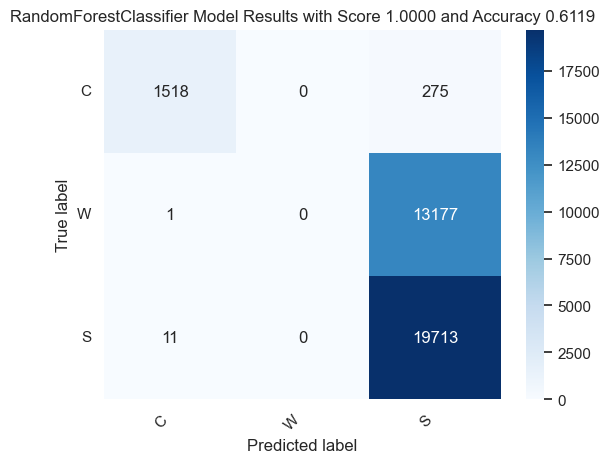

"\nfpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)\nsns.set()\nplt.plot(fpr, tpr)\nplt.plot(fpr, fpr, linestyle = '--', color = 'k')\nplt.xlabel('False positive rate')\nplt.ylabel('True positive rate')\nAUROC = np.round(roc_auc_score(y_test, y_pred_proba), 3)\nplt.title(f'RandomForestClassifier Model ROC curve; AUROC: {AUROC}');\nplt.show()\n\nfrom sklearn.metrics import precision_recall_curve\nfrom sklearn.metrics import average_precision_score\naverage_precision = average_precision_score(y_test1, y_pred_proba)\nprecision, recall, thresholds = precision_recall_curve(y_test1, y_pred_proba)\nplt.plot(recall, precision, marker='.', label='RandomForest')\nplt.xlabel('Recall')\nplt.ylabel('Precision')\nplt.legend()\naverage_precision = np.round(average_precision, 3)\nplt.title(f'Precision Recall Curve. AUPRC: {average_precision}')\nplt.show()\n"

In [163]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF.fit(X_train, y_train)
yhat = RF.predict(X_test)
print("Score: ", round(RF.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(RF.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('RandomForestClassifier Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
#plt.title('RandomForestClassifier Model Results')
plt.show() 

y_pred_proba = RF.predict_proba(np.array(X_test))[:,1]
y_test1 = y_test.replace('W',  1)
y_test1 = y_test1.replace('S',  0)
y_test1 = y_test1.replace('C',  2)

'''
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)
sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
AUROC = np.round(roc_auc_score(y_test, y_pred_proba), 3)
plt.title(f'RandomForestClassifier Model ROC curve; AUROC: {AUROC}');
plt.show()

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test1, y_pred_proba)
precision, recall, thresholds = precision_recall_curve(y_test1, y_pred_proba)
plt.plot(recall, precision, marker='.', label='RandomForest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
average_precision = np.round(average_precision, 3)
plt.title(f'Precision Recall Curve. AUPRC: {average_precision}')
plt.show()
'''

### MLP Classifier

#### This works quite well, but needs tuning

c:\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Score:  1.0
Accuracy:  0.8872748234615939
      C      W      S
C  1723     18     52
W    10  11123   2045
S    76   1710  17938


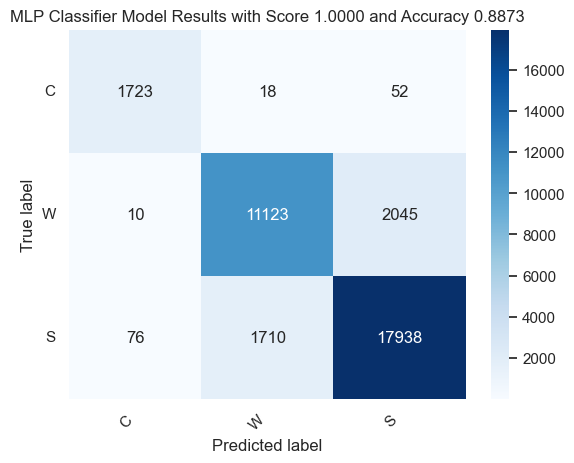

"\ny_pred_proba = NN.predict_proba(np.array(X_test))[:,1]\ny_test1 = y_test.replace('W',  1)\ny_test1 = y_test1.replace('S',  0)\ny_test1 = y_test1.replace('C',  2)\nfpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)\nsns.set()\nplt.plot(fpr, tpr)\nplt.plot(fpr, fpr, linestyle = '--', color = 'k')\nplt.xlabel('False positive rate')\nplt.ylabel('True positive rate')\nAUROC = np.round(roc_auc_score(y_test, y_pred_proba), 3)\nplt.title(f'MLPClassifier Model ROC curve; AUROC: {AUROC}');\nplt.show()\n\nfrom sklearn.metrics import precision_recall_curve\nfrom sklearn.metrics import average_precision_score\naverage_precision = average_precision_score(y_test1, y_pred_proba)\nprecision, recall, thresholds = precision_recall_curve(y_test1, y_pred_proba)\nplt.plot(recall, precision, marker='.', label='MLP')\nplt.xlabel('Recall')\nplt.ylabel('Precision')\nplt.legend()\naverage_precision = np.round(average_precision, 3)\nplt.title(f'Precision Recall Curve. AUPRC: {average_precision}')\nplt.sho

In [165]:
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, ), random_state=1,max_iter=800)
NN.fit(X_train, y_train)
yhat = NN.predict(X_test)
print("Score: ", round(NN.score(X_test,yhat), 4))
print("Accuracy: ", accuracy_score(y_test, yhat))
conmat = confusion_matrix(y_test, yhat)
val = np.mat(conmat) 
classnames = list(set(y_test))
df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
    )

print(df_cm)

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(NN.score(X_test,yhat), 4)
Accuracy_model = round(accuracy_score(y_test, yhat),4)
plt.title('MLP Classifier Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
#plt.title('MLPClassifier Model Results')
plt.show() 


'''
y_pred_proba = NN.predict_proba(np.array(X_test))[:,1]
y_test1 = y_test.replace('W',  1)
y_test1 = y_test1.replace('S',  0)
y_test1 = y_test1.replace('C',  2)
fpr, tpr, thresholds = roc_curve(y_test1, y_pred_proba)
sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
AUROC = np.round(roc_auc_score(y_test, y_pred_proba), 3)
plt.title(f'MLPClassifier Model ROC curve; AUROC: {AUROC}');
plt.show()

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test1, y_pred_proba)
precision, recall, thresholds = precision_recall_curve(y_test1, y_pred_proba)
plt.plot(recall, precision, marker='.', label='MLP')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
average_precision = np.round(average_precision, 3)
plt.title(f'Precision Recall Curve. AUPRC: {average_precision}')
plt.show()
'''


## Grid Search Method to find optimal hyper parameters
## This takes a long time to run

c:\python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (125,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.754 (+/-0.003) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.769 (+/-0.012) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'adam'}
0.773 (+/-0.004) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.724 (+/-0.018) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.772 (+/-0.010) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.778 (+/-0.007) for {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
0.776 (+/-0.125) for {'activation': 'tanh'

              precision    recall  f1-score   support

           S       0.88      0.87      0.87     13179
           W       0.91      0.92      0.92     19723

    accuracy                           0.90     32902
   macro avg       0.90      0.89      0.90     32902
weighted avg       0.90      0.90      0.90     32902



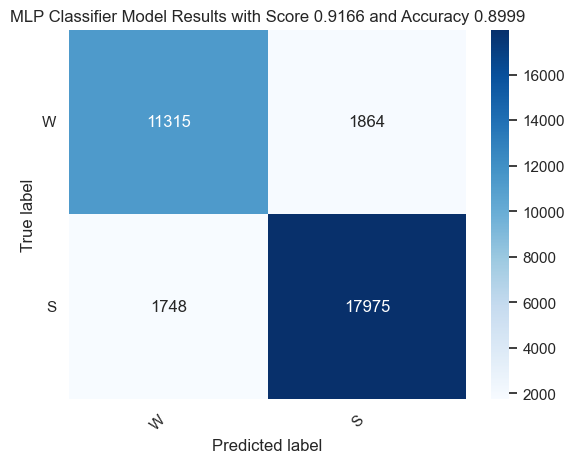

In [136]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=1000,early_stopping = True)

parameter_space = {
    'hidden_layer_sizes': [(10,),(50,), (75,), (100,), (125,)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam','lbfgs'],
    'alpha': [0.00001,0.0001,0.001,0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
y_true, y_pred = y_test , clf.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

plt.figure()
heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues",fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
Score_model = round(NN.score(X_test,y_pred), 4)
Accuracy_model = round(accuracy_score(y_test, y_pred),4)
plt.title('MLP Classifier Model Results with Score %5.4f and Accuracy %5.4f' % (Score_model, Accuracy_model))
#plt.title('MLPClassifier Model Results')
plt.show()